In [1]:
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader, Document
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core import StorageContext, load_index_from_storage
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tiktoken
enc = tiktoken.get_encoding("cl100k_base") # this is the encoding for GPT 3 and 4


In [2]:
# this is the standard and simple approach to read the data and split it into chuncks of text
documents = SimpleDirectoryReader("data/forum_threads", encoding="utf-8", errors="ignore").load_data()

Failed to load file c:\Git_Repos\BMW_RAG_support_bot\data\forum_threads\1241671.md with error: 'utf-8' codec can't decode byte 0xed in position 3048817: invalid continuation byte. Skipping...
Failed to load file c:\Git_Repos\BMW_RAG_support_bot\data\forum_threads\2049660.md with error: 'utf-8' codec can't decode byte 0xed in position 65461: invalid continuation byte. Skipping...
Failed to load file c:\Git_Repos\BMW_RAG_support_bot\data\forum_threads\2114808.md with error: 'utf-8' codec can't decode byte 0xed in position 2910: invalid continuation byte. Skipping...
Failed to load file c:\Git_Repos\BMW_RAG_support_bot\data\forum_threads\2267239.md with error: 'utf-8' codec can't decode byte 0xed in position 97261: invalid continuation byte. Skipping...
Failed to load file c:\Git_Repos\BMW_RAG_support_bot\data\forum_threads\2308846.md with error: 'utf-8' codec can't decode byte 0xed in position 1863659: invalid continuation byte. Skipping...
Failed to load file c:\Git_Repos\BMW_RAG_suppor

In [3]:
len(documents)

42251

In [4]:
files = [d.metadata["file_name"] for d in documents]
len(set(files))

1919

In [5]:
print(f"There are {len(glob.glob("data/forum_threads/*"))-len(set(files))} missing threads because of a encoding error")

There are 22 missing threads because of a encoding error


In [6]:
df_3er_and_4er_forum_threads = pd.read_pickle("data/3er_and_4er_forum_threads.pkl")

In [7]:
documents_full = []
for file in glob.glob("data/forum_threads/*"):
    with open(file, "r", encoding="utf-8", errors="replace") as f:
        file_as_text = f.read()
        thread_id = file.split("\\")[-1].removesuffix(".md")
        subsubforum = df_3er_and_4er_forum_threads["Subsubforum"][df_3er_and_4er_forum_threads["Thread_ID"] == thread_id]
        subsubforum = subsubforum.values[0]
        thread_title = df_3er_and_4er_forum_threads["Thread_Title"][df_3er_and_4er_forum_threads["Thread_ID"] == thread_id]
        thread_title = thread_title.values[0]
    documents_full.append(Document(text=file_as_text, metadata={"thread_id":thread_id, "category":subsubforum, "thread_title":thread_title}))

In [8]:
documents_full[14].metadata

{'thread_id': '1261615',
 'category': '20-1983-1991-(E30)',
 'thread_title': 'Did BMW change the Throttle position sensor to a round/6 pin connector?'}

In [9]:
len(documents_full)

1941

In [10]:
documents_full[0].metadata

{'thread_id': '1035251',
 'category': '14-1991-1999-(E36)',
 'thread_title': '1996 328is Secondary Air Pump relay location'}

## How big should my chuncks be?

Coheres website says:  
Embeddings perform best when the text to be embedded is less than 512 tokens. You can create up to 96 embeddings per API call.

Embed model stats:
| model | embedding dimension | max input tokens | cost per million |
| -- | -- | -- | -- |
| text-embedding-3-large | 3072 | 8191 | 0.13 |
| text-embedding-3-small | 1536 | 8191 | 0.02 |
| text-embedding-ada-002 | 1536 | 8191 | 0.10 |
| Cohere-embed-english-v3.0 | 1024 | 512 | 0.10 |


the maximum token length of a thread title is 28
the minimum token length of a thread title is 1
the average token length of a thread title is 9.358578052550232
the median token length of a thread title is 8


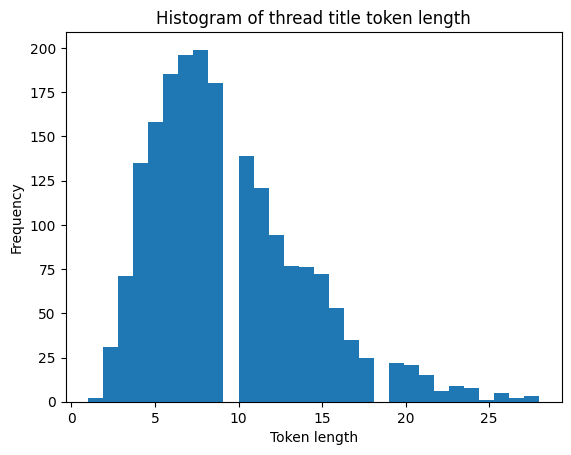

In [11]:
# How long are the thread titles in tokens
thread_titles = [d.metadata["thread_title"] for d in documents_full]
thread_titles_token_length = [len(enc.encode(t)) for t in thread_titles]

print(f"the maximum token length of a thread title is {max(thread_titles_token_length)}")
print(f"the minimum token length of a thread title is {min(thread_titles_token_length)}")
print(f"the average token length of a thread title is {sum(thread_titles_token_length)/len(thread_titles_token_length)}")
print(f"the median token length of a thread title is {sorted(thread_titles_token_length)[len(thread_titles_token_length)//2]}")
# make a histogram of the thread title token length
plt.hist(thread_titles_token_length, bins=30)
plt.xlabel("Token length")
plt.ylabel("Frequency")
plt.title("Histogram of thread title token length")
plt.show()

the maximum token length of a thread is 1371980
the minimum token length of a thread is 67
the average token length of a thread is 3737.0164863472437
the median token length of a thread is 620


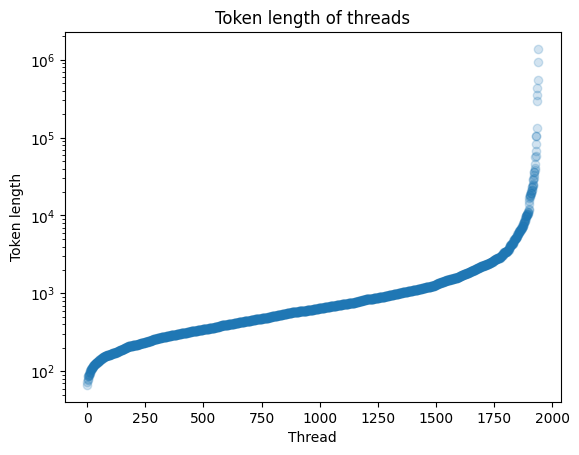

In [12]:
# how long are the threads in tokens
threads = [d.text for d in documents_full]
threads_token_length = [len(enc.encode(t)) for t in threads]

print(f"the maximum token length of a thread is {max(threads_token_length)}")
print(f"the minimum token length of a thread is {min(threads_token_length)}")
print(f"the average token length of a thread is {sum(threads_token_length)/len(threads_token_length)}")
print(f"the median token length of a thread is {sorted(threads_token_length)[len(threads_token_length)//2]}")

# make a logarithmic scatter plot of the thread token length
plt.scatter(range(len(threads_token_length)), sorted(threads_token_length), alpha=0.2)
plt.yscale("log")
plt.xlabel("Thread")
plt.ylabel("Token length")
plt.title("Token length of threads")
plt.show()

In [13]:
pd.Series(threads_token_length).value_counts().sort_index()

67         1
73         1
78         1
79         1
86         2
          ..
346693     1
437002     1
544734     1
930533     1
1371980    1
Name: count, Length: 1212, dtype: int64

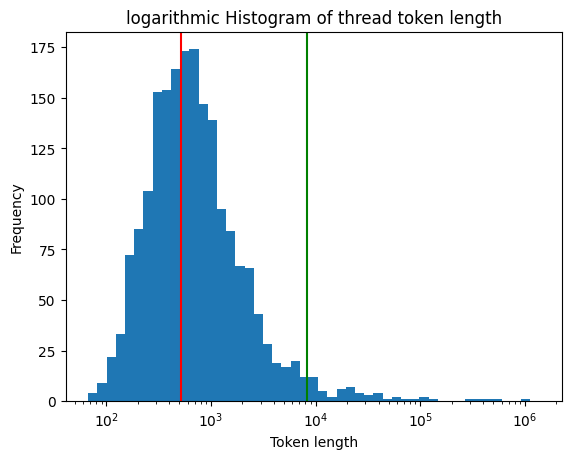

In [14]:
# make a histogram of the thread token length
plt.hist(threads_token_length, bins = 10 ** np.linspace(np.log10(67), np.log10(1371980), 50))
plt.xscale("log")
plt.xlabel("Token length")
plt.ylabel("Frequency")
plt.title("logarithmic Histogram of thread token length")
plt.axvline(x=512, color="red")
plt.axvline(x=8191, color="green")
plt.show()

I think I want to use chucks that are max 512 tokens long.  
for the others, I need to split the thread into pieces.  
The question is if I want to add the post 0 (aka the question at the top of each thread)

In [15]:
these_should_be_false = [len(t.split("## Answers"))!=2 for t in threads]
sum(these_should_be_false)

0

In [16]:
threads = [d.text for d in documents_full]
questions_token_lengths = [len(enc.encode(t.split("## Answers")[0])) for t in threads]

print(f"the maximum token length of a question is {max(questions_token_lengths)}")
print(f"the minimum token length of a question is {min(questions_token_lengths)}")
print(f"the average token length of a question is {sum(questions_token_lengths)/len(questions_token_lengths)}")
print(f"the median token length of a question is {sorted(questions_token_lengths)[len(questions_token_lengths)//2]}")

pd.Series(questions_token_lengths).value_counts().sort_index()

the maximum token length of a question is 40968
the minimum token length of a question is 37
the average token length of a question is 328.04945904173104
the median token length of a question is 207


37       1
38       1
43       1
44       4
45       1
        ..
5584     1
7228     1
7450     1
10217    1
40968    1
Name: count, Length: 606, dtype: int64

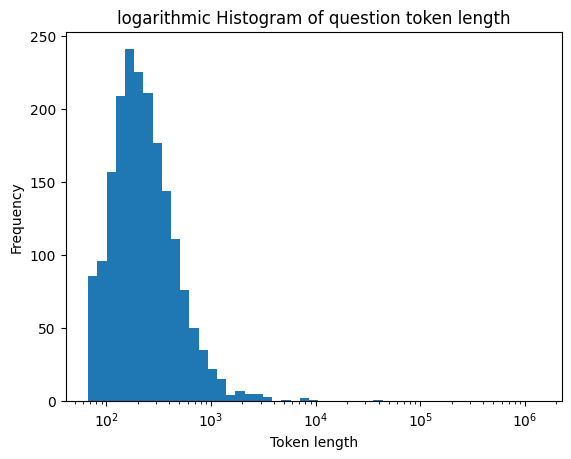

In [17]:
# make a histogram of the question token length
plt.hist(questions_token_lengths, bins = 10 ** np.linspace(np.log10(67), np.log10(1371980), 50))
plt.xscale("log")
plt.xlabel("Token length")
plt.ylabel("Frequency")
plt.title("logarithmic Histogram of question token length")
plt.show()

In [18]:
# print the questions with the longest token length
longest_questions = pd.DataFrame({"question": [t.split("## Answers")[0] for t in threads], "token_length": questions_token_lengths}).sort_values("token_length", ascending=False).head(10)
longest_questions

,question,token_length
268,# NASA Spec3 Builder's Guide (Affordable E36 r...,40968
1873,# PIC HEAVY Build Thread: 2003 Alpine White/Ci...,10217
82,# DIY Cracked Dashboard Repair [Pic Heavy]\n\n...,7450
226,# The cart before the horse: NASA Spec 3 build...,7228
110,"# DIY: TheRetrofitSource E36 Ellipsoid ""Retro-...",5584
68,# The ULTIMATE US OEM Keyless/Alarm Thread\n\n...,3817
56,# Ever wonder what all those sensors actually ...,3468
271,"# Guide to dealing with lean codes, p0171 and ...",3332
86,# The car that stole my life\n\n## Question of...,3031
286,# e21 euro parts and 323i euro bumpers (2 set...,3024


In [19]:
# print longest question to md file
# longest_questions["question"].values[0]
with open("longest_question.md", "w", encoding="utf-8") as f:
    f.write(longest_questions["question"].values[1])

Based on this information it is not really feasable to add the question to the chunks at a max token count of 512

## Try out the embedding

In [7]:
from llama_index.embeddings.openai import OpenAIEmbedding
embed_model = OpenAIEmbedding(model="text-embedding-3-small")

embeddings = embed_model.get_text_embedding(
    "Open AI new Embeddings models is great."
)


In [1]:
import os

cohere_api_key = os.environ["API_KEY_COHERE"]


from llama_index.embeddings.cohere import CohereEmbedding

# with input_typ='search_query'
embed_model = CohereEmbedding(
    cohere_api_key=cohere_api_key,
    model_name="embed-english-v3.0",
    input_type="search_document",
)

embeddings = embed_model.get_text_embedding("Hello CohereAI!")

print(len(embeddings))
print(embeddings[:5])

1024
[-0.03074646, -0.0029201508, -0.058044434, -0.015457153, -0.02331543]


In [22]:
embed_model = CohereEmbedding(
    cohere_api_key=cohere_api_key,
    model_name="embed-english-v3.0",
    input_type="search_document",
    embedding_type="int8",
)

# index = VectorStoreIndex.from_documents(
#     documents=documents, embed_model=embed_model, show_progress=True
# )
# index.storage_context.persist(persist_dir="data/embeddings/cohere")

# rebuild storage context
storage_context = StorageContext.from_defaults(persist_dir="data/embeddings/Cohere")
# load index
index = load_index_from_storage(storage_context)

In [23]:
embed_model

CohereEmbedding(model_name='embed-english-v3.0', embed_batch_size=10, callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x000001EF2A04AC00>, cohere_client=<cohere.client.Client object at 0x000001EF2A049640>, truncate='END', input_type='search_document', embedding_type='int8')

## result of the Cohere embedding
the cohere embedding created 42_251 nodes (I assume these are the number of batches.)  
The embedding took 33 minutes and cost 0.537 USD ( based on the Billing page in their Website)  
There website reported 5,374,952 Billed Tokens to me.   
There are some missing tokens, because based on the openAI encoding, I got 7_253_570 tokens
I was expecting: $0.725357 based on the OpenAI tokenizer

In [24]:
# lets see, if I can explain the difference by tokenizing with the cohere tokenizer
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("Cohere/multilingual-22-12", use_fast=True)
text = "Hellö World, this is my input string!"
enc = tokenizer(text)
print("Encoded input:")
print(enc)

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


Encoded input:
{'input_ids': [101, 72172, 24459, 17153, 117, 15272, 15002, 15456, 34429, 32542, 106, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [25]:
enc["input_ids"]

[101, 72172, 24459, 17153, 117, 15272, 15002, 15456, 34429, 32542, 106, 102]

In [26]:
thread_files = glob.glob("data/forum_threads/*.md")

total_tokens = 0
total_chars = 0
for thread_file in thread_files:
    with open(thread_file, "r", encoding="utf-8", errors='surrogatepass') as f:
        content = f.read()
        tokens = tokenizer(content)["input_ids"]
        total_tokens += len(tokens)
        total_chars += len(content)
        # print(f"{thread_file}: {len(tokens)} tokens")
print(f"Total tokens: {total_tokens}")
print(f"Total estimated tokens {total_chars / 4.8 = }")
print(f"Total price: ${total_tokens / 1_000_000 * 0.10}")
total_nodes = 42_251
print(f"The average tokens per node is {total_tokens / total_nodes}")

Token indices sequence length is longer than the specified maximum sequence length for this model (939 > 512). Running this sequence through the model will result in indexing errors


Total tokens: 7442913
Total estimated tokens total_chars / 4.8 = 5233466.666666667
Total price: $0.7442913
The average tokens per node is 176.15945184729355


In [27]:
len(embeddings)

1024

In [28]:
# index = VectorStoreIndex.from_documents(documents_full, show_progress=True)
# index.storage_context.persist(persist_dir="data/embeddings/small")


# rebuild storage context
storage_context = StorageContext.from_defaults(persist_dir="data/embeddings/small")
# load index
index = load_index_from_storage(storage_context)

The cost for this was 0,82$  
Based on my calculations I was expecting $0.725357

## try out a node based approach


In [29]:
documents_full[0]

Document(id_='d6e8efec-e48e-4cd0-8706-34553c3b3a31', embedding=None, metadata={'thread_id': '1035251', 'category': '14-1991-1999-(E36)', 'thread_title': '1996 328is Secondary Air Pump relay location'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='# 1996 328is Secondary Air Pump relay location\n\n## Question of username#6005\n\nPosted on 2008-07-02 06:21:00-04:00\n\nIn my 1996 328is the SAP relay is located in the front power distribution box\nin relay position 1 (1 out of the 15 possible).  \n  \nI was tracking down the dreaded F5/F6 fault codes and found my Pierburg air\npump was dead (internally corroded with a trickle of water falling out of the\nelectrical connector at the base!) and the check valve on the exhaust manifold\nwas carbon coated and frozen open.  \n  \nFollowing the excellent instructions by GP Burdell (formerly of Georgia Tech)\nI replaced those parts but not the rubber hoses, they were flexible and\nuncracked.  \n  \nBefore 

### MarkdownNodeParser

In [30]:
from llama_index.core.node_parser import MarkdownNodeParser

parser = MarkdownNodeParser()

nodes = parser.get_nodes_from_documents(documents_full[500:550], show_progress=True, chunk_size=512)

Parsing nodes:   0%|          | 0/50 [00:00<?, ?it/s]

In [31]:
len(nodes)

425

In [32]:
nodes[0].metadata

{'Header_1': 'M3 Steering Issue After Column Lock Removal',
 'thread_id': '2474866',
 'category': '14-1991-1999-(E36)',
 'thread_title': 'M3 Steering Issue After Column Lock Removal'}

In [33]:
for n in nodes[0:10]:
    print(n.text)
    print("_"*20)

M3 Steering Issue After Column Lock Removal
____________________
Question of username#465

Posted on 2023-04-15 12:12:00-04:00

The column lock assembly in my M3 failed as they do causing the key to no
longer be able to shut the car off.  
I got a new column lock assembly from BMW of South Atlanta and pulled the
column apart. I found that someone had previously been in the column and had
installed the "backup ring and "ring" backwards, with the ring closer to the
bearing, and had bludgeoned the snap ring into the groove locking the whole
column together. Parts seen here:  
[https://www.realoem.com/bmw/enUS/sho...diagId=32_0635](https://www.realoem.com/bmw/enUS/showparts?id=BK03-USA-05-1998-E36-BMW-M3&diagId=32_0635)  
  
I managed to get this apart and replace the steering lock. When reassembling I
put the backup ring on first as it was supposed to be, and found that the snap
ring did not align properly with the groove. Knowing that there was some level
of preload on the column bearing

Why are nodes split so wierdly?  
I dont like the way this is split.  
lets try the sentence splitter instead

In [34]:
from llama_index.core.node_parser import SentenceSplitter

splitter = SentenceSplitter(
    chunk_size=512,
    chunk_overlap=50,
)
nodes = splitter.get_nodes_from_documents(documents_full[500:1000], show_progress=True)

Parsing nodes:   0%|          | 0/500 [00:00<?, ?it/s]

In [35]:
len(nodes)

1168

In [36]:
for n in nodes[0:10]:
    print(n.text)
    print("_"*20)

# M3 Steering Issue After Column Lock Removal

## Question of username#465

Posted on 2023-04-15 12:12:00-04:00

The column lock assembly in my M3 failed as they do causing the key to no
longer be able to shut the car off.  
I got a new column lock assembly from BMW of South Atlanta and pulled the
column apart. I found that someone had previously been in the column and had
installed the "backup ring and "ring" backwards, with the ring closer to the
bearing, and had bludgeoned the snap ring into the groove locking the whole
column together. Parts seen here:  
[https://www.realoem.com/bmw/enUS/sho...diagId=32_0635](https://www.realoem.com/bmw/enUS/showparts?id=BK03-USA-05-1998-E36-BMW-M3&diagId=32_0635)  
  
I managed to get this apart and replace the steering lock. When reassembling I
put the backup ring on first as it was supposed to be, and found that the snap
ring did not align properly with the groove. Knowing that there was some level
of preload on the column bearings, I pressed th

In [37]:
import tiktoken
enc = tiktoken.get_encoding("cl100k_base") # this is the encoding for GPT 3 and 4

len(enc.encode(nodes[0].text))

414

In [38]:
l_cohere = []
l_oAI = []
for n in nodes:
    l_cohere.append(len(tokenizer(n.text)["input_ids"]))
    l_oAI.append(len(enc.encode(n.text)))
    print(l_cohere[-1], l_oAI[-1])
print(f"max length of cohere: {max(l_cohere)}")
print(f"max length of openAI: {max(l_oAI)}")

410 414
164 145
432 473
420 456
449 457
212 216
499 479
272 288
155 160
267 257
503 458
373 350
476 465
404 438
403 439
227 253
501 432
449 453
397 438
460 471
446 448
394 405
446 455
356 331
242 282
466 435
146 160
436 450
280 287
178 170
285 257
182 188
222 224
426 428
153 169
369 374
461 455
111 117
181 196
320 333
236 248
477 467
218 200
115 119
147 159
202 204
437 461
443 450
430 420
433 462
458 456
271 257
443 467
442 456
440 452
296 309
96 102
422 390
206 197
321 345
159 135
420 434
525 464
451 447
89 98
480 469
303 281
446 423
81 74
154 172
366 343
254 266
454 458
463 463
398 445
354 368
440 469
439 450
180 191
262 277
343 335
404 419
447 454
446 431
530 465
507 428
513 437
508 434
489 439
461 447
439 447
473 449
410 397
403 411
163 147
420 431
155 153
440 467
430 460
428 421
342 322
385 403
453 466
409 444
264 291
126 132
481 470
382 400
283 265
423 460
130 139
440 455
395 377
446 408
326 303
450 458
416 420
284 276
432 444
425 432
418 429
100 102
151 156
390 411
227 200
264 2

## Issue with specifying the encoding
I set the chunk_size=512 ( tokens ) but the tokenizer that is used is the one of openAI.
But I want to use the Cohere embeding model.  
This is an issue, because the cohere embedding model can only do 512 Tokens as an input.  
I need to set the correct tokenizer for llama index.

In [4]:
from llama_index.core import Settings
Settings.embed_model = CohereEmbedding(
    cohere_api_key=cohere_api_key,
    model_name="embed-english-v3.0",
    input_type="search_document",
    embed_batch_size=512
)

In [41]:
splitter = SentenceSplitter(
    chunk_size=512,
    chunk_overlap=50,
)
nodes = splitter.get_nodes_from_documents(documents_full[500:1000], show_progress=True)
print(len(nodes))

l_cohere = []
l_oAI = []
for n in nodes:
    l_cohere.append(len(tokenizer(n.text)["input_ids"]))
    l_oAI.append(len(enc.encode(n.text)))
    print(l_cohere[-1], l_oAI[-1])
print(f"max length of cohere: {max(l_cohere)}")
print(f"max length of openAI: {max(l_oAI)}")

Parsing nodes:   0%|          | 0/500 [00:00<?, ?it/s]

1168
410 414
164 145
432 473
420 456
449 457
212 216
499 479
272 288
155 160
267 257
503 458
373 350
476 465
404 438
403 439
227 253
501 432
449 453
397 438
460 471
446 448
394 405
446 455
356 331
242 282
466 435
146 160
436 450
280 287
178 170
285 257
182 188
222 224
426 428
153 169
369 374
461 455
111 117
181 196
320 333
236 248
477 467
218 200
115 119
147 159
202 204
437 461
443 450
430 420
433 462
458 456
271 257
443 467
442 456
440 452
296 309
96 102
422 390
206 197
321 345
159 135
420 434
525 464
451 447
89 98
480 469
303 281
446 423
81 74
154 172
366 343
254 266
454 458
463 463
398 445
354 368
440 469
439 450
180 191
262 277
343 335
404 419
447 454
446 431
530 465
507 428
513 437
508 434
489 439
461 447
439 447
473 449
410 397
403 411
163 147
420 431
155 153
440 467
430 460
428 421
342 322
385 403
453 466
409 444
264 291
126 132
481 470
382 400
283 265
423 460
130 139
440 455
395 377
446 408
326 303
450 458
416 420
284 276
432 444
425 432
418 429
100 102
151 156
390 411
227 200


### I can not figure out how to set the Cohere Tokenizer
So I think I will just use the OpenAI Embedding model.

## Create the Index from the Nodes Created by my text splitter


In [5]:
Settings.embed_model = OpenAIEmbedding(model="text-embedding-3-large", embed_batch_size=512)

NameError: name 'OpenAIEmbedding' is not defined

In [43]:
splitter = SentenceSplitter(
    chunk_size=512,
    chunk_overlap=50,
)
nodes = splitter.get_nodes_from_documents(documents_full, show_progress=True)

Parsing nodes:   0%|          | 0/1941 [00:00<?, ?it/s]

In [44]:
print(len(nodes))
nodes[0]

18451


TextNode(id_='088cabae-7e1c-46ba-a623-521b98ec1e30', embedding=None, metadata={'thread_id': '1035251', 'category': '14-1991-1999-(E36)', 'thread_title': '1996 328is Secondary Air Pump relay location'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='d6e8efec-e48e-4cd0-8706-34553c3b3a31', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'thread_id': '1035251', 'category': '14-1991-1999-(E36)', 'thread_title': '1996 328is Secondary Air Pump relay location'}, hash='05454f9b5bc666adcc8b74d4b28cabb0fbc6d356bf406f264e335dff87ca078f'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='eba1f640-0dd4-4ed6-8352-200fd4a37bbf', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='10ee6c399f2c7e88cc2234ce9d49e511bc09131c63cd084d98a5a2313eb8a14c')}, text="# 1996 328is Secondary Air Pump relay location\n\n## Question of username#6005\n\nPosted on 2008-07-02 06:21:00-04:00\n\nIn my 1996 328is the SAP relay is l

In [45]:
index = VectorStoreIndex.from_documents(
    documents_full,
    transformations=[splitter],
    show_progress=True
)

Parsing nodes:   0%|          | 0/1941 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/19 [00:00<?, ?it/s]

In [46]:
index.storage_context.persist(persist_dir="data/embeddings/512_text_splitter_oAI_large_embed")

In [47]:
len(nodes)

18451

### Did the indexer actually use the same nodes i got with the manual text splitting?
I could not figure out a simple way to get all of the nodes from the index, or just get the lenght of the indexed batches.
Based on the nodes_dict in the index_store.json of the stored embedding, I counted 18451 nodes.  
This checks out. Also later I could confirm, that the text in the nodes is the same, but the ids are different.

The Cost for the openAI small embedding was 0.02$

## try out the retrieving

In [48]:
from llama_index.core import  get_response_synthesizer
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.postprocessor import SimilarityPostprocessor

In [49]:
# configure retriever
retriever = VectorIndexRetriever(
    index=index,
    similarity_top_k=10,
)

In [50]:
retrieved_nodes = retriever.retrieve("my alternater is broken?")
retrieved_nodes

[NodeWithScore(node=TextNode(id_='1b3189c5-fe63-4671-aaa0-3a144f713454', embedding=None, metadata={'thread_id': '2480379', 'category': '14-1991-1999-(E36)', 'thread_title': 'Started from a jump, but didn\x92t stay on, electronics getting weaker and weaker'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='68622ec4-cb40-46f0-860c-c2adb56809e2', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'thread_id': '2480379', 'category': '14-1991-1999-(E36)', 'thread_title': 'Started from a jump, but didn\x92t stay on, electronics getting weaker and weaker'}, hash='846f4f5612af57e2ac6be7d61686a4916d9a55317df5246e23535a3baffa4bbf'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='d18cfe39-0996-4803-9473-1084767bec28', node_type=<ObjectType.TEXT: '1'>, metadata={'thread_id': '2480379', 'category': '14-1991-1999-(E36)', 'thread_title': 'Started from a jump, but didn\x92t stay on, electronics getting wea

In [51]:
[n.score for n in retrieved_nodes]

[0.4624188898876068,
 0.4597454430686255,
 0.45123268776824155,
 0.449996544218888,
 0.4449667262711428,
 0.4407143412989,
 0.43718980589150674,
 0.43561372737124143,
 0.43393155374719283,
 0.4242287250972772]

In [52]:
[len(enc.encode(n.text)) for n in retrieved_nodes]

[195, 458, 424, 428, 409, 447, 440, 442, 444, 116]

In [53]:
print(retrieved_nodes[0].node.metadata)
print(retrieved_nodes[0].node.embedding)
print(retrieved_nodes[0].node.text)
print(retrieved_nodes[0].node.id_)

{'thread_id': '2480379', 'category': '14-1991-1999-(E36)', 'thread_title': 'Started from a jump, but didn\x92t stay on, electronics getting weaker and weaker'}
None
Ive really got to be thrifty, so would like to avoid eg. paying for a new
battery only to learn that the one I had was fine  
\- is it the alternator its self? Or potentially something else  
(I had the start motor stop working but was shown a cheeky trick where by one
person take plier and bridge the body of the starter with the live wire thats
powers it while the power turns the key and that got her going)<it wasnt
possible to jump it when the starter wasnt working  
  
thanks in Advance for any assistance. 🧐


## Answers

### Post of username#6

sounds like your alternator went out. it will have over taxed the battery
while it happened as well.

### Post of username#2

I agree sounds like the alternator. You should put the battery on a proper
charger right away if you want to save it.
1b3189c5-fe63-4671-aaa0-3a144f7

In [54]:
# check if the nodes are the same
texts = [n.text for n in retrieved_nodes]
retrieved_ids = [n.id_ for n in retrieved_nodes]
summe_texts = 0
summe_ids = 0
for n in nodes:
    if n.text in texts:
        summe_texts += 1
    if n.id_ in retrieved_ids:
        summe_ids += 1
print(summe_texts == len(retrieved_nodes))
print(summe_texts)
print(summe_ids == len(retrieved_nodes))
print(summe_ids)
print(len(retrieved_nodes))
print("In this sample, the text of the nodes is exactly the same, but the ids are not")

True
10
False
0
10
In this sample, the text of the nodes is exactly the same, but the ids are not


In [55]:
for t in texts:
    print(t)
    print("_"*20)

Ive really got to be thrifty, so would like to avoid eg. paying for a new
battery only to learn that the one I had was fine  
\- is it the alternator its self? Or potentially something else  
(I had the start motor stop working but was shown a cheeky trick where by one
person take plier and bridge the body of the starter with the live wire thats
powers it while the power turns the key and that got her going)<it wasnt
possible to jump it when the starter wasnt working  
  
thanks in Advance for any assistance. 🧐


## Answers

### Post of username#6

sounds like your alternator went out. it will have over taxed the battery
while it happened as well.

### Post of username#2

I agree sounds like the alternator. You should put the battery on a proper
charger right away if you want to save it.
____________________
The
wire with the blue stripe provides 12V to the alternator to activate the
alternator to start charging the battery- Start up is the biggest drain on the
battery using 200 A

In [56]:
len(retrieved_nodes[0].node.text)

803

In [57]:
print(retrieved_nodes[9].node.text)

### Post of username#514

Had something similar happen to my M42. Exciter wire is the blue one people
are talking about. Something happened to my ignition switch resulting in the
starter hitting intermittently and alternator not being "excited" until higher
than 3500 RPM. I wired in a secret starter switch and from there I tied a
diode from the starter trigger to the exciter pin on the alternator...that way
any time the starter is triggered the alternator gets triggered to start
charging. Hope you figure it out!


In [58]:
# configure response synthesizer
response_synthesizer = get_response_synthesizer()

# assemble query engine
query_engine = RetrieverQueryEngine(
    retriever=retriever,
    response_synthesizer=response_synthesizer,
    node_postprocessors=[SimilarityPostprocessor(similarity_cutoff=0.7)],
)

# query
response = query_engine.query("What did the author do growing up?")
print(response)

Empty Response
